# PROIECT SI - DEEP LEARNING



# Rezumatul Proiectului: Clasificarea Imaginilor pe Baza Sporturilor

In cadrul acestui proiect, am dezvoltat si evaluat 3 modele de invatare automata pentru a clasifica imagini in functie de sportul care este practicat in acestea. Am explorat atat arhitecturi de retele neuronale convolutionale (CNN) construite de la zero, cat si tehnici de invatare prin transfer folosind modele pre-antrenate.

## 1. Retele Neuronale Custom (Antrenare pentru Clasificarea Sporturilor)

Am experimentat cu trei arhitecturi CNN custom, proiectate specific pentru a invata caracteristicile relevante imaginilor cu sporturi:

* **Model Custom 1 (CNN Simplu pentru Sporturi):**
    * O retea convolutionala initiala, cu doua straturi de convolutie si max pooling, urmata de un strat dens si stratul de output pentru categoriile de sporturi.
    * Optimizata cu Adam si functia de pierdere categorical crossentropy.

* **Model Custom 2 (CNN Mai Adanc cu Dropout pentru Sporturi):**
    * O arhitectura CNN mai profunda, cu trei straturi de convolutie, menita sa extraga caracteristici mai complexe din imaginile sportive.
    * A inclus un strat de Dropout pentru a reduce overfitting-ul pe datele cu sporturi.

* **Model Custom 3 (CNN cu Batch Normalization si Dropout pentru Sporturi):**
    * Un model avansat cu trei blocuri Conv2D, fiecare incorporand Batch Normalization pentru stabilizarea antrenarii si activare ReLU, urmate de MaxPooling.
    * A utilizat un strat dens cu regularizare prin Batch Normalization si Dropout inainte de clasificarea finala a sporturilor.

## 2. Invatare prin Transfer (Adaptarea Modelelor Pre-antrenate pentru Clasificarea Sporturilor)

Am aplicat invatarea prin transfer folosind trei modele recunoscute, pe care le-am adaptat pentru sarcina specifica de identificare a sporturilor:

* **Model Transfer Learning 1 (VGG16 pentru Sporturi):**
    * Am folosit modelul VGG16 pre-antrenat pe ImageNet, inghetand straturile de baza pentru a pastra cunostintele generale despre imagini.
    * Am adaugat un cap de clasificare nou, simplu, pentru a adapta modelul la recunoasterea diferitelor categorii de sporturi.

* **Model Transfer Learning 2 (ResNet50 pentru Sporturi):**
    * Am utilizat ResNet50, aplicand o tehnica de fine-tuning prin dezghetarea si reantrenarea ultimelor straturi ale modelului de baza. Aceasta a permis ajustarea caracteristicilor invatate pentru a se potrivi mai bine cu specificul imaginilor sportive.
    * Capul de clasificare adaugat a fost unul mai complex, pentru o mai buna discriminare intre sporturi.

* **Model Transfer Learning 3 (EfficientNetB0 pentru Sporturi):**
    * Am implementat un model bazat pe EfficientNetB0, antrenat in doua etape distincte pentru o adaptare optima la clasificarea sporturilor:
        1.  **Antrenarea Capului:** Initial, baza EfficientNetB0 a ramas inghetata, antrenandu-se doar noul cap de clasificare adaugat.
        2.  **Fine-tuning:** Ulterior, un numar selectat de straturi din partea superioara a EfficientNetB0 au fost dezghetate, iar intregul model a fost reantrenat cu o rata de invatare mica, pentru a specializa modelul pe nuantele vizuale ale diferitelor sporturi.

Pentru toate modelele, s-au utilizat tehnici de augmentare a datelor pe setul de antrenare pentru a creste diversitatea imaginilor sportive si a imbunatati capacitatea de generalizare a modelelor. Procesul de antrenare a fost monitorizat si optimizat folosind callback-uri precum EarlyStopping (pentru oprirea timpurie a antrenarii daca performanta pe setul de validare nu se imbunatatea), ReduceLROnPlateau (pentru ajustarea dinamica a ratei de invatare), ModelCheckpoint (pentru salvarea automata a celui mai performant model) si TensorBoard (pentru vizualizarea detaliata a metricilor de antrenare).

# Importuri si Configurare Initiala

In aceasta sectiune:

- Sunt importate bibliotecile necesare pentru procesarea imaginilor, modelare, evaluare si vizualizare (ex. NumPy, TensorFlow, Keras, OpenCV, Matplotlib, etc.)
- Se configureaza TensorFlow pentru a folosi GPU-ul, daca este disponibil, si se seteaza optiunea de alocare dinamica a memoriei
- Se definesc constantele de baza: dimensiunile imaginilor, batch size-ul si numarul de epoci
- Se seteaza caile catre directoarele cu imaginile de antrenare, validare si test
- Se verifica existenta acestor directoare si se afiseaza un mesaj de avertizare daca lipsesc

Aceasta etapa pregateste mediul si datele pentru antrenarea modelelor de clasificare a imaginilor in functie de sportul ilustrat.


In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import random
from PIL import Image
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0, MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"S-au găsit {len(gpus)} GPU-uri. Se va utiliza GPU-ul.")
    except RuntimeError as e:
        print(e)
else:
    print("Nu s-a găsit niciun GPU. Se va utiliza CPU-ul.")

IMG_WIDTH, IMG_HEIGHT = 224, 224 
BATCH_SIZE = 32 
EPOCHS = 50 

train_dir = './data/train'
test_dir = './data/test'
val_dir = './data/valid'

for dir_path in [train_dir, test_dir, val_dir]:
    if not os.path.exists(dir_path):
        print(f"AVERTISMENT: Directorul {dir_path} nu a fost găsit. Asigură-te că ai specificat căile corecte.")

print("Importuri și configurare finalizate.")

S-au găsit 1 GPU-uri. Se va utiliza GPU-ul.
Importuri și configurare finalizate.


# Afișare Imagini și Pregătirea Datelor

In aceasta sectiune sunt realizate urmatoarele actiuni:

- Se defineste o functie care afiseaza aleatoriu cateva imagini din directorul de antrenare, impreuna cu eticheta (numele subfolderului) corespunzatoare fiecarei imagini. Acest pas este util pentru a verifica vizual calitatea si structura datasetului.

- Se definesc generatoarele de imagini pentru antrenare, validare si testare folosind `ImageDataGenerator`. 
  - Pentru setul de antrenare, sunt aplicate tehnici de **data augmentation** (rotiri, translatii, zoom, flip orizontal etc.) pentru a imbunatati generalizarea modelului.
  - Pentru validare si testare, imaginile sunt doar redimensionate si scalate.

- Se incarca imaginile din directoarele `train`, `valid` si `test`, se seteaza dimensiunea target si modul de clasificare (categorial, pentru clasificare multi-clasa).

- Se afiseaza numarul de clase identificate si maparea dintre etichete si indecsi.

Aceasta etapa pregateste datele pentru antrenarea retelei si verifica daca structura fisierelor este corecta.


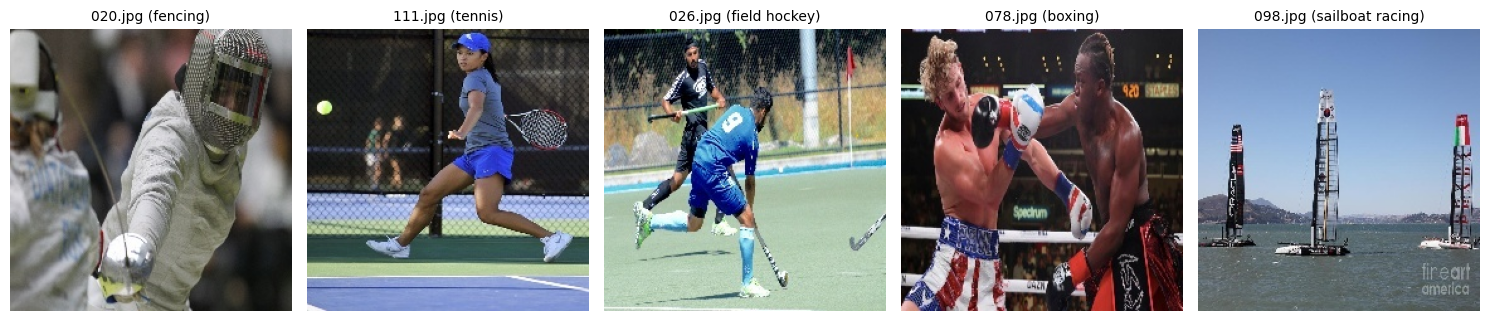

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Numărul de clase detectate: 100
Etichetele claselor: {'air hockey': 0, 'ampute football': 1, 'archery': 2, 'arm wrestling': 3, 'axe throwing': 4, 'balance beam': 5, 'barell racing': 6, 'baseball': 7, 'basketball': 8, 'baton twirling': 9, 'bike polo': 10, 'billiards': 11, 'bmx': 12, 'bobsled': 13, 'bowling': 14, 'boxing': 15, 'bull riding': 16, 'bungee jumping': 17, 'canoe slamon': 18, 'cheerleading': 19, 'chuckwagon racing': 20, 'cricket': 21, 'croquet': 22, 'curling': 23, 'disc golf': 24, 'fencing': 25, 'field hockey': 26, 'figure skating men': 27, 'figure skating pairs': 28, 'figure skating women': 29, 'fly fishing': 30, 'football': 31, 'formula 1 racing': 32, 'frisbee': 33, 'gaga': 34, 'giant slalom': 35, 'golf': 36, 'hammer throw': 37, 'hang gliding': 38, 'harness racing': 39, 'high jump': 40, 'hockey': 41, 'horse jumping': 42, 'horse racing': 43, 'hors

In [2]:
def show_random_images_with_labels(main_folder, num_images=5):

  if not os.path.exists(main_folder):
    print(f"Directorul {main_folder} nu există. Nu se pot afișa imagini.")
    return

  subfolders = [os.path.join(main_folder, f) for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]
  if not subfolders:
    print(f"Nu s-au găsit subdirectoare în {main_folder}.")
    return
  
  random.shuffle(subfolders)

  fig, axes = plt.subplots(nrows=1, ncols=min(num_images, len(subfolders)), figsize=(15, 5))
  if min(num_images, len(subfolders)) == 1: # Dacă avem o singură imagine/subfolder de afișat
      axes = [axes] 

  for i, subfolder in enumerate(subfolders[:min(num_images, len(subfolders))]):
    image_paths = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_paths:
      print(f"Nu s-au găsit imagini în {subfolder}.")
      axes[i].axis('off')
      axes[i].set_title(f"Gol ({os.path.basename(subfolder)})", fontsize=10)
      continue
      
    random.shuffle(image_paths)
    image_path = image_paths[0]

    try:
      img = Image.open(image_path)
      axes[i].imshow(img)
      axes[i].axis('off')
      axes[i].set_title(f"{os.path.basename(image_path)} ({os.path.basename(subfolder)})", fontsize=10) # [cite: 3]
    except Exception as e:
      print(f"Eroare la deschiderea imaginii {image_path}: {e}")
      axes[i].axis('off')
      axes[i].set_title(f"Eroare ({os.path.basename(subfolder)})", fontsize=10)


  plt.tight_layout()
  plt.show()

show_random_images_with_labels(train_dir, 5)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2,
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

try:
    train_dg = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode="categorical", 
        shuffle=True, 
        seed=42
    )

    validation_dg = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode="categorical", 
        shuffle=False, 
        seed=42
    )

    testing_dg = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE, 
        class_mode="categorical",
        shuffle=False, 
        seed=42
    )

    NUM_CLASSES = train_dg.num_classes
    print(f"Numărul de clase detectate: {NUM_CLASSES}")
    print(f"Etichetele claselor: {train_dg.class_indices}")

except Exception as e:
    print(f"Eroare la crearea generatoarelor de date: {e}")
    print("Verifică dacă directoarele train, val, test conțin subdirectoare pentru fiecare clasă.")
    NUM_CLASSES = 100

print("Generatoarele de date și funcția de afișare sunt gata.")

# Callback-uri pentru Antrenare

In aceasta sectiune sunt definite callback-urile folosite in timpul antrenarii modelelor:

- **TensorBoard**: salveaza loguri de antrenare in directoare separate pentru fiecare experiment, permitand monitorizarea performantei modelului (loss, accuracy etc.) in timp real.

- **EarlyStopping**: opreste antrenarea automat daca nu exista imbunatatiri ale valorii `val_loss` dupa un numar de epoci consecutive (patience), prevenind supraantrenarea. De asemenea, restaureaza automat cei mai buni parametri.

- **ReduceLROnPlateau**: reduce rata de invatare atunci cand `val_loss` nu mai scade, ajutand modelul sa ajunga la un minim local mai stabil.

- **ModelCheckpoint**: salveaza automat cel mai bun model (in functie de `val_accuracy`) in timpul antrenarii, pentru a putea fi folosit ulterior la inferenta sau evaluare.

Acesti callback-uri sunt esentiale pentru controlul eficient al procesului de antrenare si pentru imbunatatirea performantelor modelului.


In [3]:
log_dir_base = "logs/fit/"

def get_tensorboard_callback(experiment_name):
    log_dir = os.path.join(log_dir_base, experiment_name + "_" + datetime.now().strftime("%Y%m%d-%H%M%S"))
    return TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    patience=10, #
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    mode='min', 
    verbose=1
)

def get_model_checkpoint_callback(experiment_name):
    checkpoint_filepath = f"models/{experiment_name}_best_model.keras"  
    if not os.path.exists("models"):
        os.makedirs("models")
    return ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
print("Callback-uri definite.")

Callback-uri definite.


# Vizualizarea performanței în timpul antrenării

Această funcție afișează evoluția metricilor de performanță în timpul antrenării unui model de învățare automată:

- **Accuratețea** pe setul de antrenare și de validare este afișată în partea stângă.
- **Loss-ul** (eroarea) pentru setul de antrenare și de validare este afișat în partea dreaptă.

Graficul ajută la:
- Detectarea suprainvățării (overfitting), dacă performanța pe setul de validare se deteriorează în timp ce cea pe antrenare continuă să crească.
- Monitorizarea progresului modelului de la o epocă la alta.

Funcția este robustă și tratează cazurile în care datele de acuratețe sau loss nu sunt disponibile.


In [4]:
def plot_training_history(history, title="Training and Validation Metrics"):
    train_acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs_range = range(1, len(train_acc) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    if train_acc and val_acc:
        plt.plot(epochs_range, train_acc, 'b-', label='Training Accuracy')
        plt.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend() 
    else:
        plt.text(0.5, 0.5, 'Accuracy data not available', ha='center')


    plt.subplot(1, 2, 2)
    if train_loss and val_loss:
        plt.plot(epochs_range, train_loss, 'b-', label='Training Loss')
        plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Loss data not available', ha='center')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("Funcția de plotare a istoricului este gata.")

Funcția de plotare a istoricului este gata.


### Custom Model 1 - CNN Simplu

Aceasta celula defineste, compileaza si antreneaza un model de tip Convolutional Neural Network (CNN) simplu pentru clasificarea imaginilor.

Modelul contine:
- Doua straturi convolutive (Conv2D) cu 32 si 64 de filtre, urmate de straturi de pooling (MaxPooling2D).
- Un strat Flatten care transforma rezultatele convolutiilor intr-un vector 1D.
- Un strat dens intermediar cu 64 de neuroni si activare ReLU.
- Un strat de iesire cu activare `softmax`, care returneaza probabilitati pentru fiecare clasa.

Modelul este compilat cu:
- Optimizatorul Adam (rata de invatare 0.001),
- Functia de pierdere `categorical_crossentropy`,
- Metrica `accuracy`.

Sunt definite urmatoarele callbacks:
- TensorBoard pentru monitorizarea antrenamentului,
- EarlyStopping pentru oprirea timpurie daca performanta pe setul de validare nu se imbunatateste,
- ReduceLROnPlateau pentru ajustarea dinamica a ratei de invatare,
- ModelCheckpoint pentru salvarea celui mai bun model pe baza `val_accuracy`.

Daca generatoarele `train_dg` si `validation_dg` sunt disponibile, modelul va fi antrenat si istoricul antrenarii va fi afisat grafic.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 64)                1

I0000 00:00:1748711690.602531    7195 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 [==============================] - ETA: 0s - loss: 4.4016 - accuracy: 0.0395
Epoch 1: val_accuracy improved from -inf to 0.09000, saving model to models/custom_cnn_simple_best_model.keras
422/422 [==============================] - 72s 163ms/step - loss: 4.4016 - accuracy: 0.0395 - val_loss: 3.9974 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 2/50
422/422 [==============================] - ETA: 0s - loss: 3.7056 - accuracy: 0.1205
Epoch 2: val_accuracy improved from 0.09000 to 0.17200, saving model to models/custom_cnn_simple_best_model.keras
422/422 [==============================] - 60s 141ms/step - loss: 3.7056 - accuracy: 0.1205 - val_loss: 3.4077 - val_accuracy: 0.1720 - lr: 0.0010
Epoch 3/50
422/422 [==============================] - ETA: 0s - loss: 3.3510 - accuracy: 0.1774
Epoch 3: val_accuracy improved from 0.17200 to 0.23200, saving model to models/custom_cnn_simple_best_model.keras
422/422 [==============================] - 60s 143ms/step - loss: 3.3510 - accuracy: 0.177

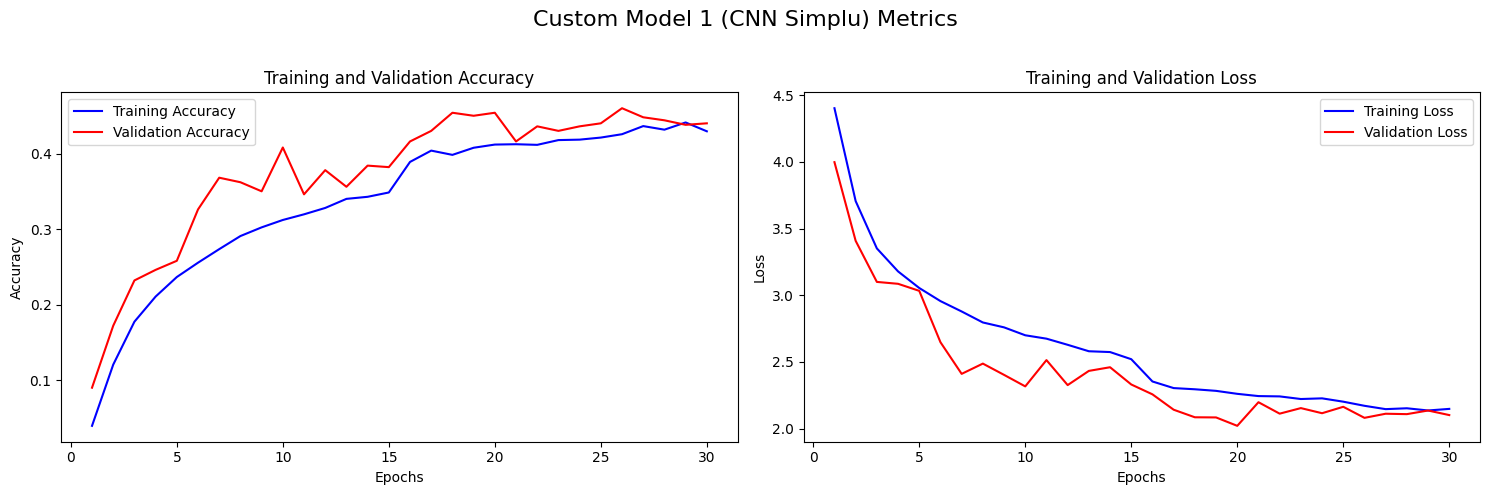

In [5]:
def build_custom_cnn_simple(input_shape, num_classes):
    model = models.Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

custom_model_1 = build_custom_cnn_simple((IMG_WIDTH, IMG_HEIGHT, 3), NUM_CLASSES)
custom_model_1.summary()

custom_model_1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

experiment_name_cm1 = "custom_cnn_simple"
callbacks_cm1 = [
    get_tensorboard_callback(experiment_name_cm1),
    early_stopping_cb,
    reduce_lr_cb,
    get_model_checkpoint_callback(experiment_name_cm1)
]

if 'train_dg' in globals() and 'validation_dg' in globals() and train_dg is not None and validation_dg is not None:
    print("\nAntrenare Custom Model 1 (CNN Simplu)...")
    history_cm1 = custom_model_1.fit(
        train_dg,
        epochs=EPOCHS,
        validation_data=validation_dg, # [cite: 12]
        callbacks=callbacks_cm1
    )
    plot_training_history(history_cm1, "Custom Model 1 (CNN Simplu) Metrics")
else:
    print("Eroare: train_dg sau validation_dg nu sunt disponibile. Antrenarea nu poate începe.")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 28, 28, 128)      

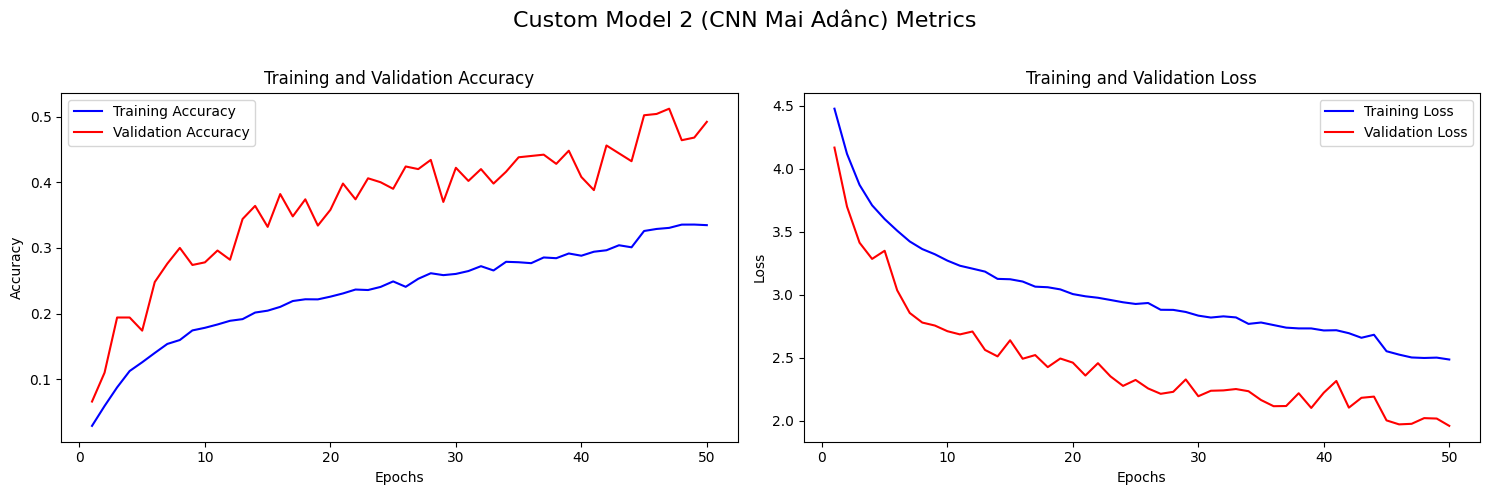

In [6]:
def build_custom_cnn_deeper(input_shape, num_classes):
    model = models.Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

custom_model_2 = build_custom_cnn_deeper((IMG_WIDTH, IMG_HEIGHT, 3), NUM_CLASSES)
custom_model_2.summary()

custom_model_2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

experiment_name_cm2 = "custom_cnn_deeper"
callbacks_cm2 = [
    get_tensorboard_callback(experiment_name_cm2),
    early_stopping_cb,
    reduce_lr_cb,
    get_model_checkpoint_callback(experiment_name_cm2)
]

if 'train_dg' in globals() and 'validation_dg' in globals() and train_dg is not None and validation_dg is not None:
    print("\nAntrenare Custom Model 2 (CNN Mai Adânc)...")
    history_cm2 = custom_model_2.fit(
        train_dg,
        epochs=EPOCHS,
        validation_data=validation_dg,
        callbacks=callbacks_cm2
    )
    plot_training_history(history_cm2, "Custom Model 2 (CNN Mai Adânc) Metrics")
else:
    print("Eroare: train_dg sau validation_dg nu sunt disponibile. Antrenarea nu poate începe.")

### Custom Model 2 - CNN Mai Adanc

Aceasta celula defineste, compileaza si antreneaza un model CNN mai adanc pentru clasificarea imaginilor.

Modelul contine:
- Trei straturi convolutive (Conv2D) cu 32, 64 si 128 filtre, toate cu padding 'same' pentru a pastra dimensiunile caracteristice,
- Fiecare strat convolutiv este urmat de un strat de max pooling (MaxPooling2D) pentru reducerea spatiala,
- Stratul Flatten transforma rezultatele in vector 1D,
- Un strat dens cu 128 neuroni si activare ReLU,
- Strat Dropout cu rata 0.5 pentru regularizare si reducerea suprainvatarii,
- Strat final de iesire cu activare softmax pentru clasificare multi-clasa.

Modelul este compilat cu:
- Optimizator Adam (learning rate 0.001),
- Functia de pierdere `categorical_crossentropy`,
- Metrica `accuracy`.

Sunt definite aceleasi callbacks ca si pentru modelul simplu:
- TensorBoard,
- EarlyStopping,
- ReduceLROnPlateau,
- ModelCheckpoint.

Daca generatoarele de date `train_dg` si `validation_dg` sunt disponibile, modelul va fi antrenat si istoricul antrenarii va fi afisat prin grafice.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)     

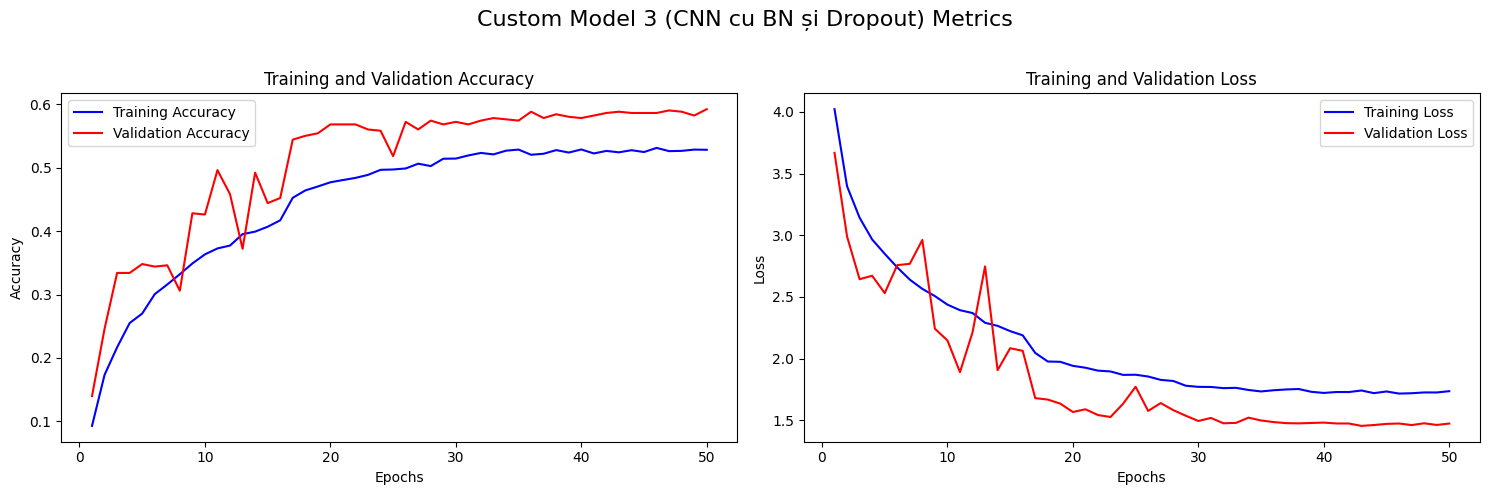

In [7]:
def build_custom_cnn_bn_dropout(input_shape, num_classes):
    model = models.Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        layers.Activation('relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        layers.Activation('relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        layers.Activation('relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(256),
        BatchNormalization(),
        layers.Activation('relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

custom_model_3 = build_custom_cnn_bn_dropout((IMG_WIDTH, IMG_HEIGHT, 3), NUM_CLASSES)
custom_model_3.summary()

custom_model_3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

experiment_name_cm3 = "custom_cnn_bn_dropout"
callbacks_cm3 = [
    get_tensorboard_callback(experiment_name_cm3),
    early_stopping_cb,
    reduce_lr_cb,
    get_model_checkpoint_callback(experiment_name_cm3)
]

if 'train_dg' in globals() and 'validation_dg' in globals() and train_dg is not None and validation_dg is not None:
    print("\nAntrenare Custom Model 3 (CNN cu BN și Dropout)...")
    history_cm3 = custom_model_3.fit(
        train_dg,
        epochs=EPOCHS,
        validation_data=validation_dg,
        callbacks=callbacks_cm3
    )
    plot_training_history(history_cm3, "Custom Model 3 (CNN cu BN și Dropout) Metrics")
else:
    print("Eroare: train_dg sau validation_dg nu sunt disponibile. Antrenarea nu poate începe.")

### Functie pentru construire model Transfer Learning

Aceasta functie construieste un model de clasificare bazat pe transfer learning folosind un model pre-antrenat ca baza.

Parametrii principali:
- `base_model_fn`: functia care returneaza modelul de baza pre-antrenat (ex: `tf.keras.applications.ResNet50`),
- `input_shape`: forma imaginilor de intrare,
- `num_classes`: numarul de clase pentru clasificare,
- `head_type`: tipul capului de retea adaugat deasupra modelului de baza (`'simple'` sau `'complex'`),
- `trainable_base_layers`: cate straturi din modelul de baza sa fie antrenabile (0 = toate inghetate, -1 = toate antrenabile, >0 = ultimele N straturi antrenabile).

Procesul:
- Se incarca modelul de baza fara stratul superior (`include_top=False`) si cu greutati pre-antrenate pe ImageNet,
- Se seteaza care straturi sunt antrenabile in functie de `trainable_base_layers`,
- Se adauga un strat de global average pooling pentru reducerea dimensiunii caracteristicilor extrase,
- Se construieste un cap nou (head) pentru clasificare, fie simplu (un Dense + Dropout), fie complex (Dense-uri multiple cu BatchNormalization si Dropout),
- Se adauga stratul final Dense cu activare softmax pentru clasificarea pe numarul dorit de clase,
- Se returneaza modelul final compilat.

Aceasta functie permite flexibilitate in alegerea modelului de baza, a configuratiei capului si a stratului de antrenare, facilitand experimente rapide cu transfer learning.



In [8]:
def build_transfer_learning_model(base_model_fn, input_shape, num_classes, head_type='simple', trainable_base_layers=0):
    
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)

    if trainable_base_layers == 0:
        base_model.trainable = False
    elif trainable_base_layers == -1:
        base_model.trainable = True 
    elif trainable_base_layers > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-trainable_base_layers]:
            layer.trainable = False
    
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False if trainable_base_layers == 0 else True) # training=False dacă base_model.trainable = False
    x = GlobalAveragePooling2D()(x)
    
    if head_type == 'simple':
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
    elif head_type == 'complex':
        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
    else: # Default la un head simplu
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

print("Funcția ajutătoare pentru transfer learning este gata.")

Funcția ajutătoare pentru transfer learning este gata.


## Descrierea funcției `build_transfer_learning_model`

Această funcție construiește un model de transfer learning bazat pe un model pre-antrenat disponibil în Keras (de exemplu, VGG16, ResNet50).

### Argumente:
- **base_model_fn**: Funcția care returnează modelul de bază pre-antrenat fără stratul superior (include_top=False).
- **input_shape**: Forma imaginilor de intrare (ex: `(IMG_WIDTH, IMG_HEIGHT, 3)`).
- **num_classes**: Numărul de clase pentru clasificarea finală.
- **head_type**: Tipul stratului superior (head) folosit pentru clasificare:
  - `'simple'` — strat dens cu 128 neuroni și dropout 0.3,
  - `'complex'` — straturi dense mai mari, batch normalization și dropout,
  - orice altceva — se folosește stratul simplu implicit.
- **trainable_base_layers**: Controlează câte straturi din modelul de bază sunt antrenabile:
  - `0` — toate straturile modelului de bază sunt înghețate (nu se antrenează),
  - `-1` — toate straturile modelului de bază sunt antrenabile (fine-tuning complet),
  - orice număr pozitiv — ultimele *n* straturi sunt antrenabile, restul sunt înghețate.

### Cum funcționează:
1. Se încarcă modelul de bază pre-antrenat fără stratul superior, cu greutăți ImageNet.
2. Se setează proprietatea `trainable` pentru straturile modelului de bază conform argumentului `trainable_base_layers`.
3. Se adaugă un strat de *Global Average Pooling* pentru a reduce dimensiunile output-ului modelului de bază.
4. Se adaugă un cap (head) de clasificare conform parametrului `head_type`.
5. Ultimul strat este un strat dens cu activare softmax pentru clasificarea în `num_classes` clase.
6. Se returnează modelul complet, gata de compilare și antrenare.

Această funcție facilitează experimentarea cu diferite configurații de transfer learning și fine-tuning, simplificând procesul de construire a modelelor.

---
*Funcția este pregătită pentru a fi utilizată în proiecte de clasificare de imagini cu rețele neurale convoluționale pre-antrenate.*


In [12]:
from tensorflow.keras import models 

def build_transfer_learning_model(base_model_fn, input_shape, num_classes, head_type='simple', trainable_base_layers=0):
    """
    Construiește un model de transfer learning.
    Args:
        base_model_fn: O funcție care returnează modelul de bază pre-antrenat (ex: VGG16, ResNet50).
        input_shape: Dimensiunea imaginilor de intrare.
        num_classes: Numărul de clase de ieșire.
        head_type: 'simple' sau 'complex' pentru diferite arhitecturi ale stratului de clasificare.
        trainable_base_layers: Numărul de straturi de la sfârșitul modelului de bază care să fie antrenabile.
                               Dacă 0, toate straturile de bază sunt înghețate.
                               Dacă -1, toate straturile de bază sunt antrenabile (fine-tuning complet).
    """
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)

    if trainable_base_layers == 0:
        base_model.trainable = False
    elif trainable_base_layers == -1:
        base_model.trainable = True 
    elif trainable_base_layers > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-trainable_base_layers]:
            layer.trainable = False
    
    inputs = Input(shape=input_shape) 
    x = base_model(inputs, training= (False if trainable_base_layers == 0 else True) if base_model.trainable else False)
    x = GlobalAveragePooling2D()(x) 
    
    if head_type == 'simple':
        x = Dense(128, activation='relu')(x) 
        x = Dropout(0.3)(x) 
    elif head_type == 'complex':
        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x) 
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
    else: 
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        
    outputs = Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

print("Funcția ajutătoare pentru transfer learning este gata .")

Funcția ajutătoare pentru transfer learning este gata .


## Descrierea codului pentru construirea și antrenarea modelului Transfer Learning cu ResNet50

Această celulă configurează, compilează și antrenează un model de transfer learning folosind arhitectura **ResNet50** pre-antrenată pe ImageNet.

### Pași realizați:

1. **Construirea modelului**  
   Se apelează funcția `build_transfer_learning_model` cu următorii parametri:  
   - Modelul de bază: `ResNet50`  
   - Forma imaginii de intrare: `(IMG_WIDTH, IMG_HEIGHT, 3)`  
   - Numărul de clase: `NUM_CLASSES`  
   - Tipul stratului superior (head): `'complex'` (mai multe straturi dense, batch normalization, dropout)  
   - Numărul de straturi antrenabile în modelul de bază: `5` (ultimele 5 straturi sunt fine-tunate, restul sunt înghețate)  

2. **Sumarizarea arhitecturii modelului**  
   Se afișează structura rețelei cu `summary()`.

3. **Compilarea modelului**  
   - Optimizator: Adam cu learning rate mic (0.0001) pentru fine-tuning stabil  
   - Funcția de pierdere: categorical_crossentropy (pentru clasificare multi-clasă)  
   - Metriși: acuratețe

4. **Configurarea callback-urilor**  
   Se configurează callback-uri pentru:  
   - TensorBoard (vizualizare în timp real)  
   - Early stopping (oprire automată dacă nu mai există îmbunătățire)  
   - Reducerea ratei de învățare când performanța stagnează  
   - Salvarea modelului optim (checkpoint)

5. **Antrenarea modelului**  
   Dacă există generatori de date pentru antrenare și validare (`train_dg` și `validation_dg`), modelul se antrenează pe `EPOCHS` epoci, cu date de validare și callback-uri configurate.  
   Se afișează graficul cu evoluția metricilor de antrenament și validare.

6. **Gestionarea erorilor**  
   Dacă generatorii de date nu sunt disponibili, se afișează un mesaj de eroare.

---

*Acest cod realizează fine-tuning-ul parțial al modelului ResNet50, adaptându-l la problema curentă de clasificare cu un cap complex de clasificare, optimizat pentru rezultate mai bune pe datele specifice task-ului.*


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_4 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 512)               0     

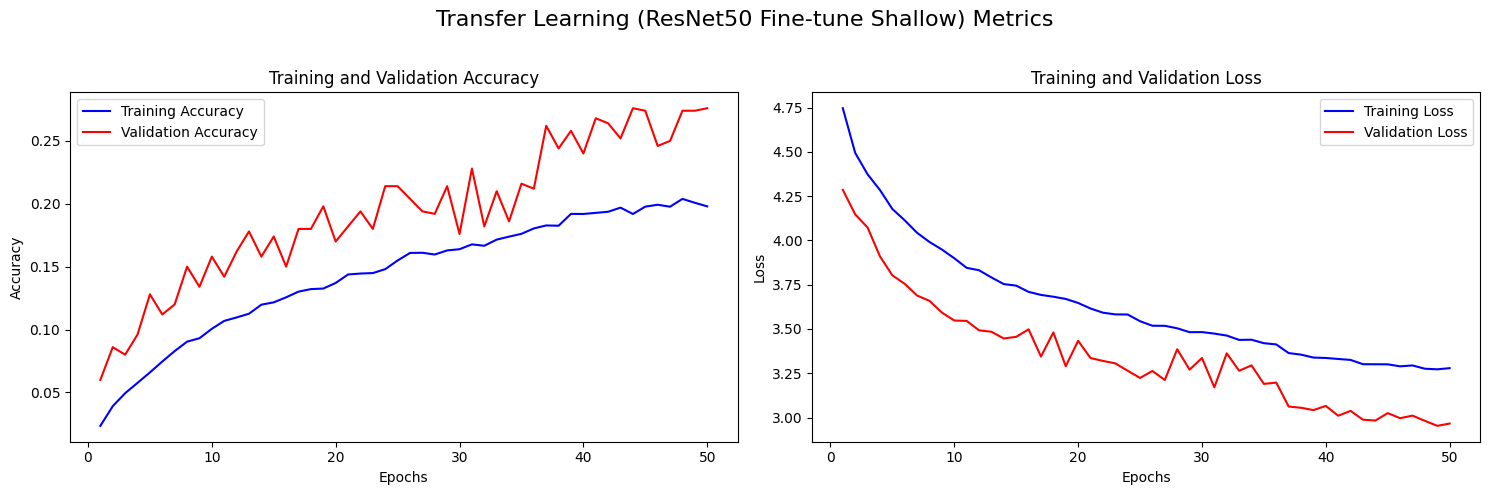

In [14]:
tl_model_2_resnet50 = build_transfer_learning_model(
    ResNet50,
    (IMG_WIDTH, IMG_HEIGHT, 3),
    NUM_CLASSES,
    head_type='complex',
    trainable_base_layers=5 
) 
tl_model_2_resnet50.summary()

tl_model_2_resnet50.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

experiment_name_tl2 = "transfer_resnet50_finetune_shallow"
callbacks_tl2 = [
    get_tensorboard_callback(experiment_name_tl2),
    early_stopping_cb,
    reduce_lr_cb,
    get_model_checkpoint_callback(experiment_name_tl2)
]

if 'train_dg' in globals() and 'validation_dg' in globals() and train_dg is not None and validation_dg is not None:
    print("\nAntrenare Transfer Learning Model 2 (ResNet50 Fine-tune Shallow)...")
    history_tl2 = tl_model_2_resnet50.fit(
        train_dg,
        epochs=EPOCHS, 
        validation_data=validation_dg,
        callbacks=callbacks_tl2
    )
    plot_training_history(history_tl2, "Transfer Learning (ResNet50 Fine-tune Shallow) Metrics")
else:
    print("Eroare: train_dg sau validation_dg nu sunt disponibile. Antrenarea nu poate începe.")


Transfer Learning Model 3 (EfficientNetB0) - Etapa 1: Antrenare Head
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_13 (Dense)            (None, 256)               327936    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                       

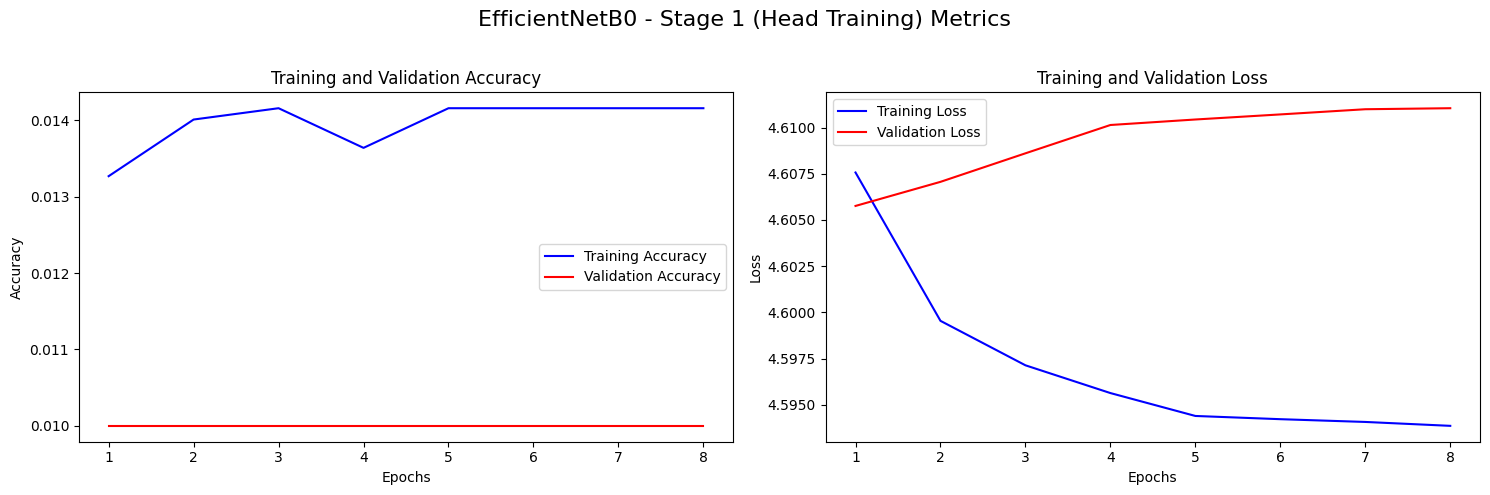


Transfer Learning Model 3 (EfficientNetB0) - Etapa 2: Fine-tuning
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_13 (Dense)            (None, 256)               327936    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                          

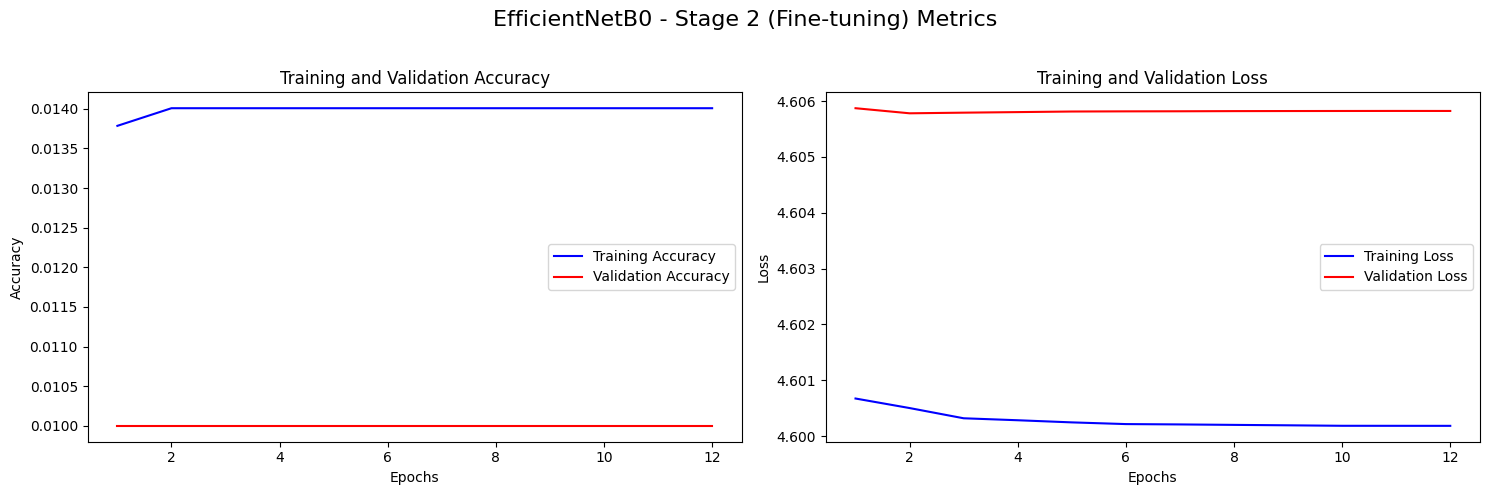

In [16]:
print("\nTransfer Learning Model 3 (EfficientNetB0) - Etapa 1: Antrenare Head")
base_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_efficientnet.trainable = False

inputs_eff = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x_eff = base_efficientnet(inputs_eff, training=False)
x_eff = GlobalAveragePooling2D()(x_eff)
x_eff = Dense(256, activation='relu')(x_eff)
x_eff = Dropout(0.4)(x_eff)
outputs_eff = Dense(NUM_CLASSES, activation='softmax')(x_eff)
tl_model_3_efficientnet = tf.keras.models.Model(inputs_eff, outputs_eff)

tl_model_3_efficientnet.summary()

tl_model_3_efficientnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

experiment_name_tl3_stage1 = "transfer_efficientnet_stage1_head"
callbacks_tl3_stage1 = [
    get_tensorboard_callback(experiment_name_tl3_stage1),
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-5, verbose=1),
    get_model_checkpoint_callback(experiment_name_tl3_stage1)
]

if 'train_dg' in globals() and 'validation_dg' in globals() and train_dg is not None and validation_dg is not None:
    history_tl3_stage1 = tl_model_3_efficientnet.fit(
        train_dg,
        epochs=20,
        validation_data=validation_dg,
        callbacks=callbacks_tl3_stage1
    )
    plot_training_history(history_tl3_stage1, "EfficientNetB0 - Stage 1 (Head Training) Metrics")

    print("\nTransfer Learning Model 3 (EfficientNetB0) - Etapa 2: Fine-tuning")
    
    base_efficientnet.trainable = True
    fine_tune_at = len(base_efficientnet.layers) // 3
    
    for layer in base_efficientnet.layers[:-fine_tune_at]:
        layer.trainable = False
    
    tl_model_3_efficientnet.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    tl_model_3_efficientnet.summary()

    experiment_name_tl3_stage2 = "transfer_efficientnet_stage2_finetune"
    callbacks_tl3_stage2 = [
        get_tensorboard_callback(experiment_name_tl3_stage2),
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4, min_lr=1e-7, verbose=1),
        get_model_checkpoint_callback(experiment_name_tl3_stage2)
    ]

    history_tl3_stage2 = tl_model_3_efficientnet.fit(
        train_dg,
        epochs=EPOCHS,
        initial_epoch=history_tl3_stage1.epoch[-1] + 1 if 'history_tl3_stage1' in locals() and history_tl3_stage1.epoch else 0,
        validation_data=validation_dg,
        callbacks=callbacks_tl3_stage2
    )
    plot_training_history(history_tl3_stage2, "EfficientNetB0 - Stage 2 (Fine-tuning) Metrics")
else:
    print("Eroare: train_dg sau validation_dg nu sunt disponibile. Antrenarea nu poate începe.")

## Descrierea codului pentru încărcarea, evaluarea și inferența modelului de clasificare

Această celulă realizează următoarele operații:

1. **Încărcarea modelului**  
   - Se încearcă încărcarea unui model salvat de pe disk (`best_model_path`).  
   - Dacă modelul nu există sau apare o eroare, se folosește ultimul model antrenat disponibil în sesiune (`tl_model_3_efficientnet`), dacă există.  
   - Se gestionează erorile de încărcare cu mesaje informative.

2. **Evaluarea modelului pe setul de test**  
   - Dacă modelul și generatorul de date pentru test (`testing_dg`) sunt disponibili, se evaluează modelul pe setul de test, afișând pierderea (loss) și acuratețea.  
   
3. **Generarea raportului de clasificare și a matricei de confuzie complete**  
   - Se obțin etichetele adevărate și predicțiile pentru toate imaginile din setul de test.  
   - Se afișează raportul de clasificare complet (precizie, recall, F1-score) pentru toate clasele.  
   - Se afișează matricea de confuzie completă cu o hartă de căldură (heatmap).

4. **Generarea matricei de confuzie pentru un subset de clase**  
   - Dacă se specifică o listă de indici pentru un subset de clase, se generează matricea de confuzie doar pentru aceste clase, filtrând doar exemplele unde eticheta adevărată și cea prezisă apar în subset.  
   - Dacă lista este goală sau invalidă, se afișează mesaje informative și se omite această parte.

5. **Funcție pentru inferență pe o singură imagine**  
   - Se încarcă și preprocessază o imagine dată ca input.  
   - Modelul face o predicție și se afișează imaginea cu eticheta prezisă și încrederea asociată.  
   - Se gestionează erorile legate de fișierul imaginii sau predicție.

6. **Test inferență pe o imagine de test din set**  
   - Dacă există imagini în directorul de test, se selectează o imagine aleatorie din primul subfolder de clasă găsit și se face inferența cu afișarea rezultatului.  
   - Dacă nu sunt imagini disponibile, se afișează un mesaj corespunzător.

7. **Gestionarea absenței modelului sau a generatorului de test**  
   - Dacă modelul sau generatorul de test nu sunt disponibili, se afișează un mesaj de avertizare.


Se încarcă modelul: models/transfer_efficientnet_stage2_finetune_best_model.keras

Evaluare pe setul de testare...
16/16 [==============================] - 2s 46ms/step - loss: 4.6059 - accuracy: 0.0100
Loss pe setul de testare: 4.6059
Acuratețe pe setul de testare: 0.0100

Generare raport de clasificare și matrice de confuzie (completă)...
16/16 [==============================] - 1s 44ms/step

Raport de Clasificare (complet):
                       precision    recall  f1-score   support

           air hockey       0.00      0.00      0.00         5
      ampute football       0.00      0.00      0.00         5
              archery       0.00      0.00      0.00         5
        arm wrestling       0.00      0.00      0.00         5
         axe throwing       0.00      0.00      0.00         5
         balance beam       0.00      0.00      0.00         5
        barell racing       0.00      0.00      0.00         5
             baseball       0.00      0.00      0.00         5
 

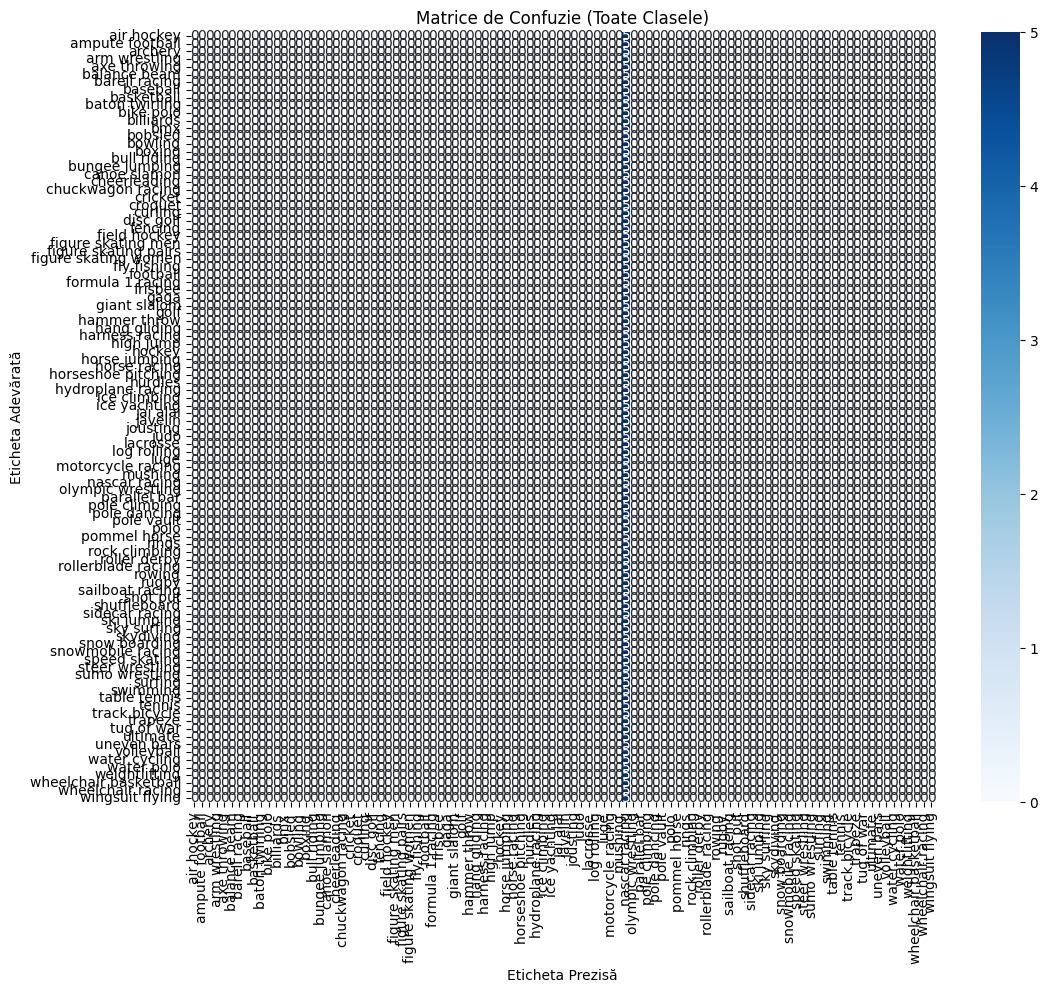


Generare matrice de confuzie pentru un subset de clase...
Nu au fost specificați indici pentru matricea de confuzie redusă. Se omite.

Inferență pe imaginea de test: ./data/test/ice climbing/5.jpg
1/1 [==============================] - 1s 622ms/step


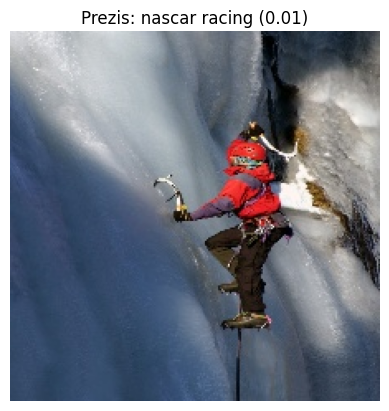

In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import seaborn as sns 

try:
    best_model_path = "models/transfer_efficientnet_stage2_finetune_best_model.keras" # Exemplu
    if not os.path.exists(best_model_path):
        print(f"Modelul {best_model_path} nu a fost găsit. Folosind ultimul model antrenat, tl_model_3_efficientnet, dacă există.")
        if 'tl_model_3_efficientnet' in globals():
             model_to_evaluate = tl_model_3_efficientnet
        else:
            print("Niciun model antrenat disponibil pentru evaluare.")
            model_to_evaluate = None
    else:
        print(f"Se încarcă modelul: {best_model_path}")
        model_to_evaluate = load_model(best_model_path)
        
except Exception as e:
    print(f"Eroare la încărcarea modelului: {e}")
    print("Folosind ultimul model antrenat, tl_model_3_efficientnet, dacă există.")
    if 'tl_model_3_efficientnet' in globals():
         model_to_evaluate = tl_model_3_efficientnet
    else:
        print("Niciun model antrenat disponibil pentru evaluare.")
        model_to_evaluate = None


if model_to_evaluate and 'testing_dg' in globals() and testing_dg is not None:
    print("\nEvaluare pe setul de testare...")
    loss, accuracy = model_to_evaluate.evaluate(testing_dg, verbose=1)
    print(f"Loss pe setul de testare: {loss:.4f}")
    print(f"Acuratețe pe setul de testare: {accuracy:.4f}")

    print("\nGenerare raport de clasificare și matrice de confuzie (completă)...")
    true_labels_all = testing_dg.classes
    predictions_probabilities_all = model_to_evaluate.predict(testing_dg, steps=len(testing_dg), verbose=1)
    predicted_labels_all = np.argmax(predictions_probabilities_all, axis=1)
    
    all_class_labels_list = list(testing_dg.class_indices.keys())
    
    print("\nRaport de Clasificare (complet):")
    print(classification_report(true_labels_all, predicted_labels_all, target_names=all_class_labels_list, zero_division=0))

    print("\nMatrice de Confuzie (completă):")
    cm_all = confusion_matrix(true_labels_all, predicted_labels_all)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_all, annot=True, fmt="d", cmap="Blues", xticklabels=all_class_labels_list, yticklabels=all_class_labels_list)
    plt.title('Matrice de Confuzie (Toate Clasele)')
    plt.ylabel('Eticheta Adevărată')
    plt.xlabel('Eticheta Prezisă')
    plt.show()

    print("\nGenerare matrice de confuzie pentru un subset de clase...")
    
    # PASUL
    selected_class_indices_of_interest = [] 
    if not selected_class_indices_of_interest:
        print("Nu au fost specificați indici pentru matricea de confuzie redusă. Se omite.")
    elif not all(isinstance(i, int) and 0 <= i < NUM_CLASSES for i in selected_class_indices_of_interest):
        print("Lista 'selected_class_indices_of_interest' conține valori invalide. Asigură-te că sunt indici întregi valizi.")
    else:
        selected_class_names = [all_class_labels_list[i] for i in selected_class_indices_of_interest]
        
        original_to_new_idx_map = {original_idx: new_idx for new_idx, original_idx in enumerate(selected_class_indices_of_interest)}
        
        filtered_true_labels = []
        filtered_predicted_labels = []
        
        for i in range(len(true_labels_all)):
            original_true = true_labels_all[i]
            original_pred = predicted_labels_all[i]
            
            if original_true in selected_class_indices_of_interest and original_pred in selected_class_indices_of_interest:
                filtered_true_labels.append(original_to_new_idx_map[original_true])
                filtered_predicted_labels.append(original_to_new_idx_map[original_pred])
        
        if not filtered_true_labels:
            print("Nu s-au găsit instanțe care să corespundă criteriilor pentru clasele selectate (atât true cât și predicted în subset).")
        else:
            print(f"\nMatrice de Confuzie (Subset de {len(selected_class_names)} Clase):")
            cm_subset = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=list(range(len(selected_class_names))))
            
            plt.figure(figsize=(max(8, len(selected_class_names)), max(6, len(selected_class_names) - 2))) # Ajustează dimensiunea
            sns.heatmap(cm_subset, annot=True, fmt="d", cmap="Blues", 
                        xticklabels=selected_class_names, 
                        yticklabels=selected_class_names)
            plt.title(f'Matrice de Confuzie ({len(selected_class_names)} Clase Selectate)')
            plt.ylabel('Eticheta Adevărată (Subset)')
            plt.xlabel('Eticheta Prezisă (Subset)')
            plt.show()

    def predict_single_image(img_path, model, class_labels_list_param):
        try:
            img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0

            prediction = model.predict(img_array)
            predicted_class_index = np.argmax(prediction, axis=1)[0]
            predicted_class_label = class_labels_list_param[predicted_class_index]
            confidence = np.max(prediction)

            plt.imshow(Image.open(img_path))
            plt.title(f"Prezis: {predicted_class_label} ({confidence:.2f})")
            plt.axis('off')
            plt.show()
            return predicted_class_label, confidence
        except FileNotFoundError:
            print(f"Eroare: Fișierul imagine {img_path} nu a fost găsit.")
            return None, None
        except Exception as e:
            print(f"Eroare la prezicerea imaginii {img_path}: {e}")
            return None, None

    if os.path.exists(test_dir) and any(os.scandir(test_dir)):
        first_class_folder_path = None
        for entry in os.scandir(test_dir):
            if entry.is_dir():
                first_class_folder_path = entry.path
                break
        
        if first_class_folder_path and any(os.scandir(first_class_folder_path)):
            sample_image_name = next(e.name for e in os.scandir(first_class_folder_path) if e.is_file())
            sample_image_path = os.path.join(first_class_folder_path, sample_image_name)
            print(f"\nInferență pe imaginea de test: {sample_image_path}")
            predict_single_image(sample_image_path, model_to_evaluate, all_class_labels_list)
        else:
            print("Nu s-au găsit imagini în directoarele de clasă din setul de test pentru inferență singulară.")
    else:
        print("Directorul de test este gol sau nu există.")
else:
    print("Modelul sau generatorul de testare nu este disponibil pentru evaluare și inferențe.")